# Analyze ULRs tweeted by US politicians

In [1]:
import pandas as pd
import numpy as np
from os.path import join
from os import listdir

import sys
sys.path.append('../../../../utilities/twitter_functions')
import twitter_functions as tf

## Massage data

In [2]:
src = "../../data/twitter"
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2021-12-14_clean.csv.gzip"

df = pd.read_csv(join(src, fname),
                 compression="gzip",
                 usecols=["id", "author_id", "created_at", "expanded_urls"])

/home/jana/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df["expanded_urls"] = df["expanded_urls"].fillna("[]")
df["expanded_urls"] = df["expanded_urls"].apply(lambda x: eval(x))
df["has_url"] = df["expanded_urls"].apply(lambda x: len(x) > 0)

In [4]:
urls = df['expanded_urls'].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 'value']].set_index('index')

In [9]:
urls = pd.merge(
    urls,
    df[['id']],
    left_index=True,
    right_index=True).rename(columns={'value_x': 'expanded_urls'})

In [13]:
df = pd.merge(df, urls, left_on="id", right_on="id", how="left")

In [18]:
df["N_urls"] = df["expanded_urls"].apply(lambda x: len(x))
df = df.rename(columns={"value":"url"})

In [19]:
df.to_csv(join(src, "combined_US_politician_twitter_timelines_2010-11-06_to_2021-12-14_clean_urls.csv.gzip"),
          compression="gzip", index=False)

## Import unraveled URLs

In [ ]:
df = pd.read_csv(join(src, "combined_US_politician_twitter_timelines_2010-11-06_to_2021-12-14_clean_urls.csv.gzip"),
          compression="gzip")

In [21]:
no_urls = df[df["has_url"] == False].copy()
df = df[df["has_url"] == True]

In [23]:
unraveled_urls = pd.read_csv(join(src, "unraveled_urls.csv.xz"),
                             compression="xz")

In [27]:
df = pd.merge(df, unraveled_urls, left_on="url", right_on="url", how="left")

In [29]:
df["shortened"] = False
df.loc[df["unraveled_url"].dropna().index, "shortened"] = True

In [32]:
df.loc[df["unraveled_url"].dropna().index, "url"] = df.loc[df["unraveled_url"].dropna().index, "unraveled_url"]

In [34]:
df = df.drop(columns=["unraveled_url"])

In [ ]:
df["domain"] = df["url"].apply(tf.extract_domain)

## Find fishy domains with newsguard data

In [36]:
newsguard_src = "../../data/newsguard/newsguard_2022-03/03"
nutrition_labels = pd.read_csv(join(newsguard_src, "metadata-2022030100.csv"))

In [37]:
nutrition_labels["fishy"] = 0
nutrition_labels.loc[(nutrition_labels["Score"] <= 25).index, "fishy"] = 1
fishy_domains = set(nutrition_labels[nutrition_labels["fishy"] == 1]["Domain"])

In [38]:
df["fishy"] = 0
df.loc[df[df["domain"].idomainssin(fishy_domains)].index, "fishy"] = 1

## Count fishy domains in politician Tweets

In [42]:
N_shortened = len(df[(df["shortened"] == True)])
N_shortened_fishy = len(df[(df["shortened"] == True) & (df["fishy"] == 1)])
print("{}/{} ({:1.2f}%) shortened domains are fishy"\
      .format(N_shortened_fishy, N_shortened, 
              (N_shortened_fishy / N_shortened) * 100))

66220/188687 (35.10%) shortened domains are fishy


In [43]:
N_unshortened = len(df[(df["shortened"] == False)])
N_unshortened_fishy = len(df[(df["shortened"] == False) & (df["fishy"] == 1)])
print("{}/{} ({:1.2f}%) unshortened domains are fishy"\
      .format(N_unshortened_fishy, N_unshortened, 
              (N_unshortened_fishy / N_unshortened) * 100))

266365/1682663 (15.83%) unshortened domains are fishy


In [64]:
print("{}/{} ({:1.2f}%) of links are shortened"\
      .format(N_shortened, N_shortened + N_unshortened,
              (N_shortened / (N_shortened + N_unshortened)) * 100))

188687/1871350 (10.08%) of links are shortened


In [44]:
no_urls["shortened"] = False
no_urls["domain"] = np.nan
no_urls["fishy"] = 0
all_tweets = pd.concat([df, no_urls])

In [50]:
fishy_tweet_count = all_tweets[["id", "fishy"]]\
    .groupby("id")\
    .sum()

In [53]:
N_tweets = len(fishy_tweet_count)
N_fishy_tweets = len(fishy_tweet_count[fishy_tweet_count["fishy"] > 0])
print("{}/{} ({:1.2f}%) tweets contain fishy urls"\
      .format(N_fishy_tweets, N_tweets, (N_fishy_tweets / N_tweets) * 100))

316444/2419706 (13.08%) tweets contain fishy urls


In [58]:
all_tweets["author_id"] = all_tweets["author_id"].astype(int)

In [67]:
fishy_user_count = all_tweets[["author_id", "fishy"]]\
    .groupby("author_id")\
    .agg(["sum", "count"])

In [62]:
fishy_user_count[fishy_user_count["fishy"] == 0]

,fishy
author_id,
102477372.0,0
24905240.0,0
58883032.0,0
8.67807218468606e+17,0
946946130.0,0


In [69]:
fishy_user_count["share"] = fishy_user_count["fishy"]["sum"] / fishy_user_count["fishy"]["count"]

In [72]:
fishy_user_count["share"].max()

0.5792498487598307

/tmp/ipykernel_687967/1479185061.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "background" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fishy_share.png", background=True)


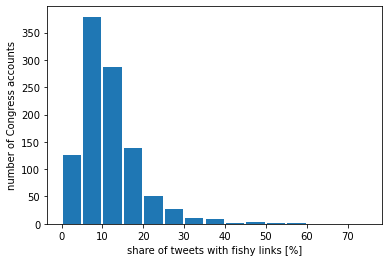

In [81]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(fishy_user_count["share"] * 100, 
        bins=np.arange(0, 80, 5), rwidth=0.9)
ax.set_xlabel("share of tweets with fishy links [%]")
ax.set_ylabel("number of Congress accounts")
plt.savefig("fishy_share.png")